# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to solve a differential equation

## Imports

In [10]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


from squlearn import Executor
from squlearn.encoding_circuit import (
    KyriienkoEncodingCircuit,
)
from squlearn.encoding_circuit.layered_encoding_circuit import Layer
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, ODELoss, get_lr_decay
from squlearn.optimizers import Adam

We will use the Pennylane quantum framework for executing the circuits.

In [11]:
executor = Executor("pennylane", shots=None)

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC), that implements $\ket{f_{\bm{\theta}, \phi}(x)} = U_{\bm{\theta}} U_{\phi}(x) \ket{0}$.

  $U_{\phi}(x)$ encodes the ODE information and $U_{\bm{\theta}}$ manipulates the function space.

In [23]:
nqubits = 6

circuit = KyriienkoEncodingCircuit(
    num_qubits=nqubits,
    encoding_style="chebyshev_tower",
    variational_arrangement="HEA",
    num_features=1,
    num_encoding_layers=1,
    num_variational_layers=5,
)

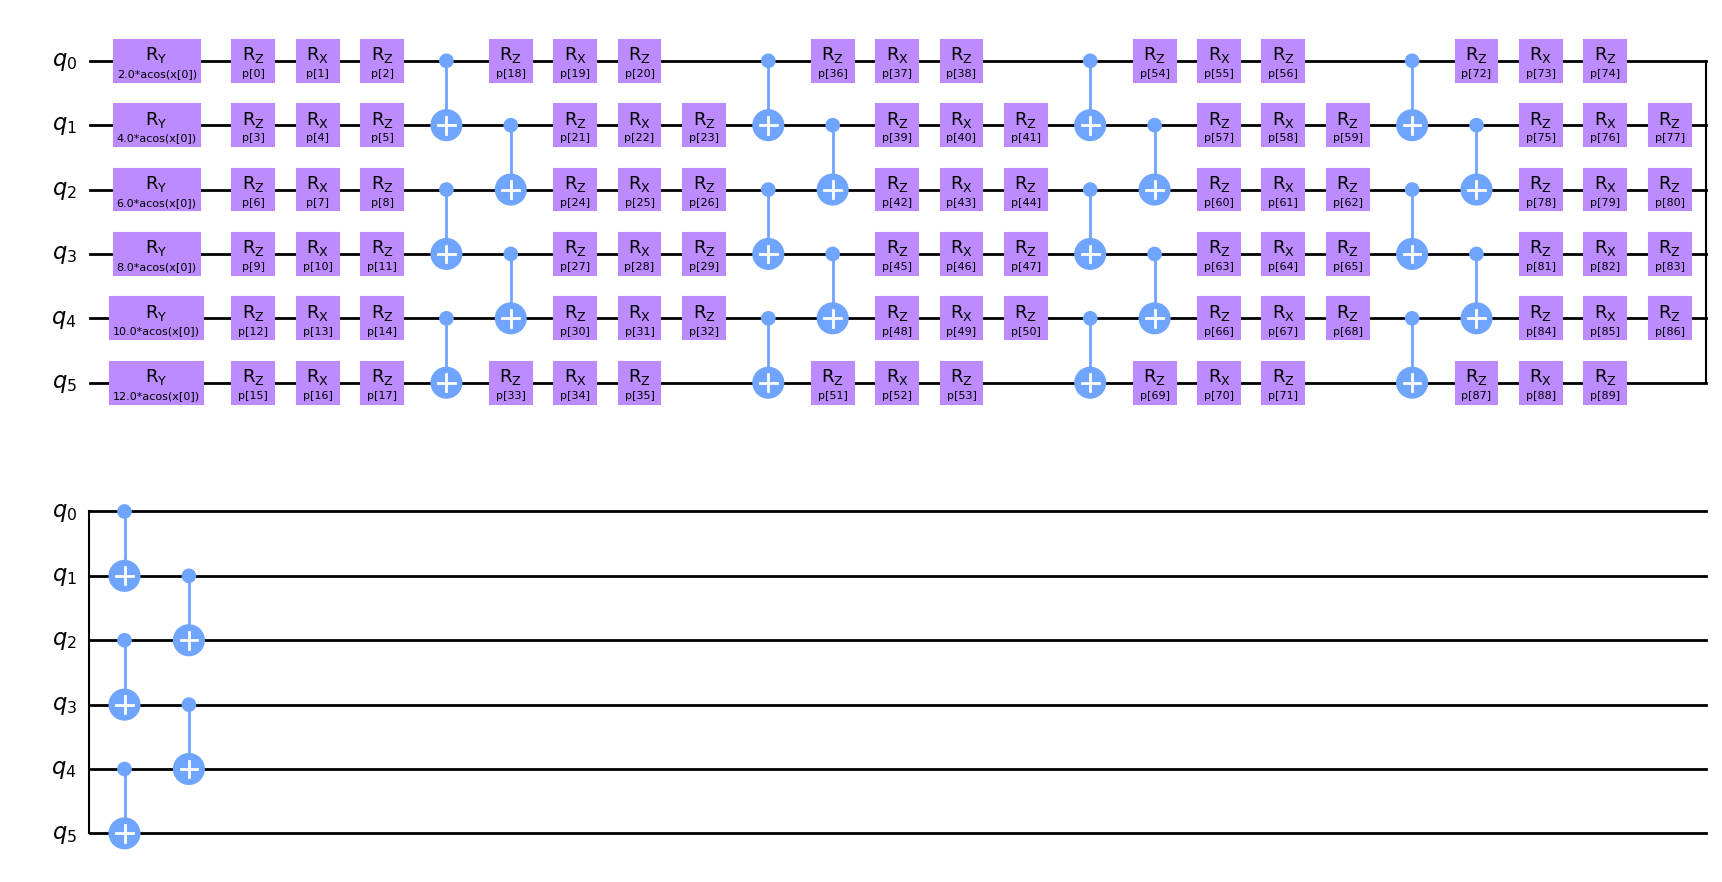

In [24]:
circuit.draw("mpl")

We also need an observable

In [25]:
observable = SummedPaulis(nqubits, include_identity=True)
print(observable)

SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4]), ParameterExpression(1.0*p[5]),
 ParameterExpression(1.0*p[6])])



We create the homogeneous differential equation to be solved using a sympy symbolic expression


In [26]:
x = sp.symbols("x")
f, dfdx, dfdxdx = sp.symbols("f dfdx dfdxdx")
k = 0.1
lamb = 20
eq = lamb * sp.exp(-lamb * x * k) * sp.sin(lamb * x) + lamb * k * f + dfdx
initial_values = [1]

In [16]:
eq

dfdx + 2.0*f + 20*exp(-2.0*x)*sin(20*x)

Now we need to create an instance of `ODELoss`, the symbols involved in the ODE must be provided in the correct order: independent variable, function, and higher orders

In [27]:
loss_ODE_sp = ODELoss(
    eq,
    symbols_involved_in_ODE=[x, f, dfdx],
    initial_values=initial_values,
    boundary_handling="pinned",
)

Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `loss_ODE` and `Adam` as the loss function and optimizer respectively. 

In [28]:
param_obs = observable.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1)


adam = Adam(options={"maxiter": 125, "tol": 0.00009, "lr": get_lr_decay(0.05, 0.02, 125)})

ode_regressor = QNNRegressor(
    circuit,
    observable,
    executor,
    loss_ODE_sp,
    adam,
    param_ini,
    param_obs,
    opt_param_op=True,
)

## Training

Now we are ready to train the model to solve the differential equation, (this takes time, around 120min)

In [29]:
x_space = np.linspace(0, 0.9, 15)
ref_values = np.zeros_like(x_space)
ode_regressor.fit(x_space, ref_values)

fit: 100%|██████████| 125/125 [1:48:59<00:00, 52.32s/it]


## Evaluation

Let's check the trained parameters of the PQC and operator

In [30]:
print("Result PQC params:", ode_regressor.param)
print("Result operator params:", ode_regressor.param_op)

Result PQC params: [-0.83880732  2.76778428 -6.59410369 -2.87130285 -4.57065774 -5.516561
 -4.05952761 -1.98817041 -1.82687533  0.22491011 -1.30979516  1.89010824
 -3.77355186  5.40393818 -6.32751553  2.1019444  -1.18523232  0.45239486
 -4.83138667 -4.02732928  3.71717188  5.57348568 -1.94255893  2.58574297
  4.77865603  5.32741616 -4.94174979 -5.55746394 -3.58716015  4.85295237
 -4.74139131 -0.48191244  6.11223159 -0.02315234  2.12539209 -1.84892219
  2.28154394  4.26956357 -5.77896492  3.20171407  5.66740972  2.94586634
 -2.58375957  3.47069428 -5.14172945 -0.52121265  4.86960734 -2.66686684
 -2.27766508 -4.76161852 -6.53148247  2.12262877 -4.21623295 -2.82118402
  0.16850832 -5.1132707   0.64253086 -5.06044595  1.29573961  2.43697705
 -5.66482216 -1.46432011  3.0735997  -1.33620542 -5.32180431  0.72407929
  2.50569042  0.02458708  6.02871128  0.82990669  4.92899119 -5.19629307
 -4.82184555  3.520252   -1.2858304  -4.61108121  5.70147821 -1.91303054
  3.6707055   2.82559787  4.816766

Also let's plot the predicted function vs. the analytical solution

Text(0.5, 0, 'x')

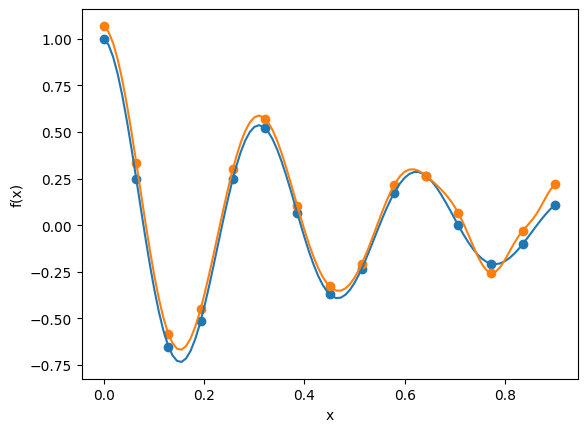

In [31]:
x = np.linspace(0, 0.9, 15)
y = ode_regressor.predict(x)
plt.scatter(x, np.cos(20 * x) * np.exp(-20 * 0.1 * x))
plt.scatter(x, y)

x_span = np.linspace(0, 0.9, 100)
y_span = ode_regressor.predict(x_span)

plt.plot(x_span, np.cos(20 * x_span) * np.exp(-20 * 0.1 * x_span))
plt.plot(x_span, y_span)

plt.ylabel("f(x)")
plt.xlabel("x")